In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
plt.style.use('ggplot')
import tensorflow as tf
keras = tf.keras

# **DATA PREPARATION**

## Read dataset and Initial Processing

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/mdrkb/avocado-prices/master/avocado_updated.csv', 
                 parse_dates=['Date'])

## There are 5 main regions and 48 sub regions

In [3]:
all_regions = df.region.unique()

regions = ['West', 'Northeast', 'Southeast', 'SouthCentral','Midsouth']

total_US = ['TotalUS']

sub_regions = []
for reg in df.region.unique():
    if reg not in regions and reg not in total_US:
        sub_regions.append(reg)

print("5 Regions: ", regions, "\r\n")
print("48 Sub regions", sub_regions)

5 Regions:  ['West', 'Northeast', 'Southeast', 'SouthCentral', 'Midsouth'] 

48 Sub regions ['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', 'BuffaloRochester', 'California', 'Charlotte', 'Chicago', 'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver', 'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton', 'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville', 'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale', 'Nashville', 'NewOrleansMobile', 'NewYork', 'NorthernNewEngland', 'Orlando', 'Philadelphia', 'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland', 'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento', 'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina', 'Spokane', 'StLouis', 'Syracuse', 'Tampa', 'WestTexNewMexico']


## Filter Dataset to get Average Prices of **"organic"** avocado for all 5 regions

In [4]:
avocado_type = list(df["type"].unique())
print("Avocado Types: ", avocado_type)

region_df = df[df["region"].isin(regions)]
region_df = region_df[region_df["type"]=="organic"][["Date","AveragePrice","region"]]
region_df = region_df.sort_values(["region","Date"])
region_df = region_df.set_index("Date")

region_df_with_region = pd.concat([region_df,pd.get_dummies(region_df.region)], axis=1)

Avocado Types:  ['conventional', 'organic']


## Splitting dataset in Train and Test, for each of 5 regions, 80% of data is taken for training.
## Preparing data for supervised learning with window size 10.

In [5]:
def sequential_window_dataset(series, window_size,shift_val=1):
    ds = tf.data.Dataset.from_tensor_slices(series,)
    ds = ds.window(window_size + 1, shift=shift_val, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)


train_dataset_list = []
test_dataset_list = []
forecast_df = region_df_with_region[0:0]

for reg in regions:
    reg_df = region_df_with_region[region_df_with_region.region == reg]
    train_size = int(np.floor(reg_df.AveragePrice.count() * 0.8)) 
    reg_train_df = reg_df[:train_size]
    reg_test_df = reg_df[train_size:]
    reg_train_series = reg_train_df.drop(columns=["region"]).values
    reg_test_series = reg_test_df.drop(columns=["region"]).values
    
    reg_train_ds = sequential_window_dataset(reg_train_series,10,shift_val=2)
    train_dataset_list.append(reg_train_ds)
    reg_test_ds = sequential_window_dataset(reg_test_series,10,shift_val=5)
    test_dataset_list.append(reg_test_ds)
    
    forecast_df = forecast_df.append(reg_test_df)

In [6]:
test_dataset = None
train_dataset = None

count=0
for i in train_dataset_list:
    if count == 0:
        train_dataset = i
    else:
        train_dataset = train_dataset.concatenate(i)
    count = count + 1

count=0 
for i in test_dataset_list:
    if count == 0:
        test_dataset = i
    else:
        test_dataset = test_dataset.concatenate(i)
    count = count + 1

## Plotting the Average Prices for 5 regions

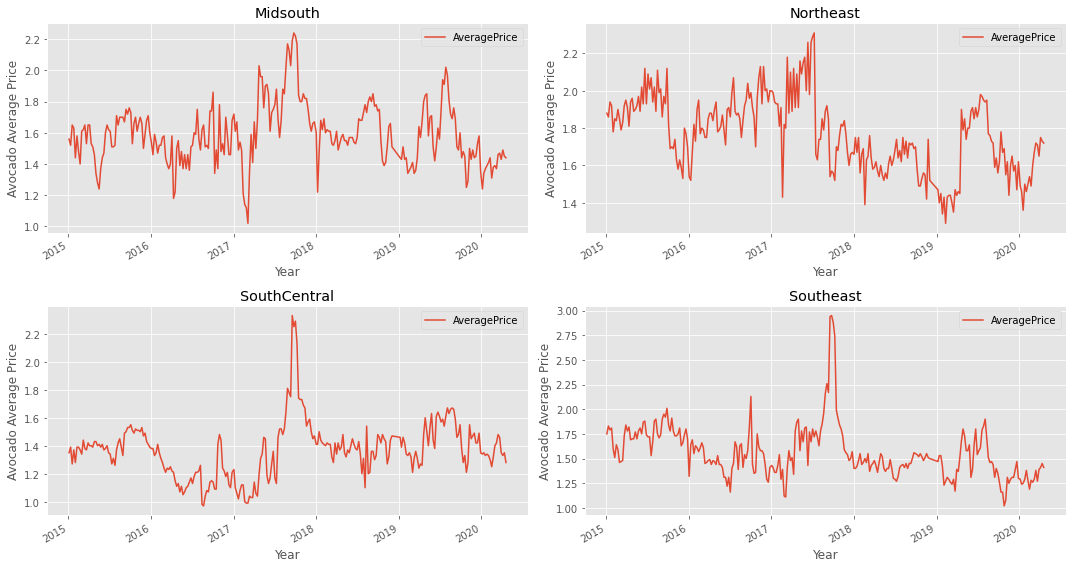

In [7]:
reg_names = list(region_df.region.unique())[:4]
df_list = []
for reg_name in reg_names:
    df_list.append(region_df[region_df.region==reg_name][["AveragePrice"]])
    
nrow=2
ncol=2
fig, axes = plt.subplots(nrow, ncol)
count=0
for r in range(nrow):
    for c in range(ncol):
        axi = df_list[count].plot(ax=axes[r,c],title=reg_names[count],figsize=(15,8))
        axi.set_ylabel("Avocado Average Price")
        axi.set_xlabel("Year")
        plt.tight_layout()
        count = count+1

# **LSTM MODEL**

## Learning rate optimization

In [8]:
lstm_model = keras.models.Sequential([
  keras.layers.LSTM(30, return_sequences=True,batch_input_shape=[1,None,6]),
  keras.layers.Dense(6),
  keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-06 * 10**(epoch / 10))

optimizer = keras.optimizers.Adam(lr=1e-6)
lstm_model.compile(loss='mse',
              optimizer=optimizer,
              metrics=["mae","mse"])


lstm_lr_history = lstm_model.fit(train_dataset, epochs=50,
                    callbacks=[lr_schedule])

Epoch 1/50
520/520 [==============================] - 3s 6ms/step - loss: 871.3958 - mae: 22.1580 - mse: 871.3955 - lr: 1.0000e-06
Epoch 2/50
520/520 [==============================] - 3s 6ms/step - loss: 817.7366 - mae: 21.3767 - mse: 817.7368 - lr: 1.2589e-06
Epoch 3/50
520/520 [==============================] - 3s 6ms/step - loss: 753.3441 - mae: 20.4456 - mse: 753.3444 - lr: 1.5849e-06
Epoch 4/50
520/520 [==============================] - 3s 6ms/step - loss: 681.0707 - mae: 19.3778 - mse: 681.0706 - lr: 1.9953e-06
Epoch 5/50
520/520 [==============================] - 3s 6ms/step - loss: 602.7466 - mae: 18.1777 - mse: 602.7466 - lr: 2.5119e-06
Epoch 6/50
520/520 [==============================] - 3s 6ms/step - loss: 520.7083 - mae: 16.8610 - mse: 520.7084 - lr: 3.1623e-06
Epoch 7/50
520/520 [==============================] - 3s 6ms/step - loss: 437.8287 - mae: 15.4461 - mse: 437.8287 - lr: 3.9811e-06
Epoch 8/50
520/520 [==============================] - 3s 6ms/step - loss: 357.2135 

##Plotting Loss vs Learning to find optimal learning rate

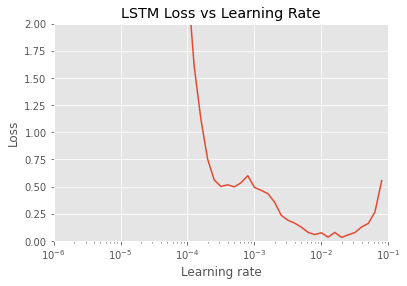

In [9]:
plt.semilogx(lstm_lr_history.history["lr"], lstm_lr_history.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.axis([1e-6, 1e-1, 0, 2])
plt.title("LSTM Loss vs Learning Rate")
plt.show()

## Training the LSTM model

In [10]:
lstm_model = keras.models.Sequential([
  keras.layers.LSTM(30,batch_input_shape=[1,None,6],name="first",return_sequences=True),
  keras.layers.Dense(6,name="third")
])

optimizer = keras.optimizers.Adam(lr=1e-2)

lstm_model.compile(loss='mse',
              optimizer=optimizer,
              metrics=["mse","mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "lstm_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=30)

lstm_history = lstm_model.fit(train_dataset, epochs=50,
          validation_data=test_dataset ,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
    519/Unknown - 4s 7ms/step - loss: 0.0286 - mse: 0.0286 - mae: 0.0790WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: lstm_checkpoint/assets
520/520 [==============================] - 10s 20ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0.0789 - val_loss: 0.2655 - val_mse: 0.2655 - val_mae: 0.3107
Epoch 2/50
520/520 [==============================] - 10s 18ms/step - loss: 0.0325 - mse: 0.0325 - mae: 0.0854 - val_loss: 0.2169 - val_mse: 0.2169 - val_mae: 0.3169
Epoch 3/50
520/520 [==============================] - 10s 19ms/step - loss: 0.0275 - mse: 0.0275 - mae: 0.0827 - val_loss: 0.1327 - val_mse: 0.1327 - val_mae: 0.2633
Epoch 4/50
520/

## Plotting Validation Loss and Training Loss for LSTM

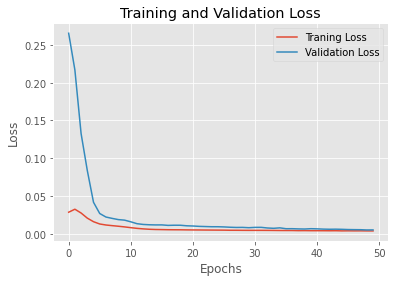

In [11]:
plt.plot(lstm_history.history["loss"], label="Traning Loss")
plt.plot(lstm_history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
# plt.savefig("training_val_loss.jpg")
plt.show()

##Choose the **model** from checkpoints

In [13]:
lstm_model = keras.models.load_model("lstm_checkpoint")

## Model evaluation

In [14]:
def get_metrics(test_set):
    metrics = lstm_model.metrics_names
    metric_val = lstm_model.evaluate(test_set)
    metric_string = "\r\n  Loss is - " + str(metric_val[0]) + ",\r\n  Mean Absolute Error is  -  " +  str(metric_val[2]) + \
    ",\r\n  Mean Squared Error is  -  " + str(metric_val[1]) \
    + ",\r\n  Root Mean Squared Error is  -  "       +   str(np.sqrt(metric_val[1]))
    return metric_string

# Printing metrics for 2 regions out of 5
forecast_regions = list(forecast_df.region.unique())
for each_region in forecast_regions:
  f_df = forecast_df[forecast_df.region==each_region]
  f_series = f_df.drop("region",axis=1).values
  f_ds = sequential_window_dataset(f_series,13,shift_val=13)
  m = get_metrics(f_ds)
  print("For Region - ",each_region,m)
  print("\r\n")

4/4 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0523
For Region -  West 
  Loss is - 0.0055844783782958984,
  Mean Absolute Error is  -  0.052259452641010284,
  Mean Squared Error is  -  0.0055844783782958984,
  Root Mean Squared Error is  -  0.07472936757591288


4/4 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0565
For Region -  Northeast 
  Loss is - 0.006298842374235392,
  Mean Absolute Error is  -  0.05647963657975197,
  Mean Squared Error is  -  0.006298842374235392,
  Root Mean Squared Error is  -  0.07936524664004636


4/4 [==============================] - 0s 4ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0675
For Region -  Southeast 
  Loss is - 0.007570136804133654,
  Mean Absolute Error is  -  0.06750299036502838,
  Mean Squared Error is  -  0.007570137269794941,
  Root Mean Squared Error is  -  0.08700

## LSTM: Predict and plot the prediction for few regions


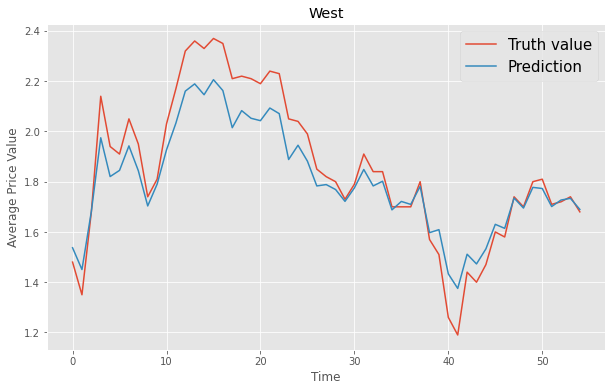

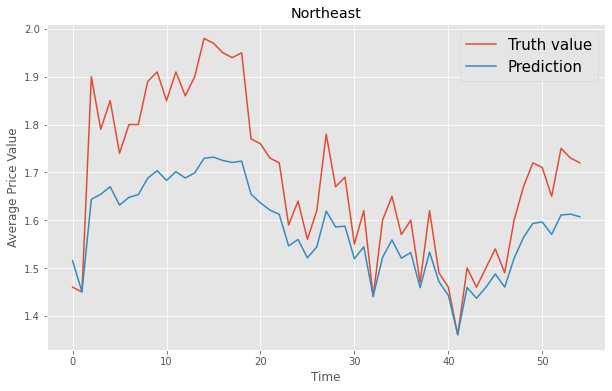

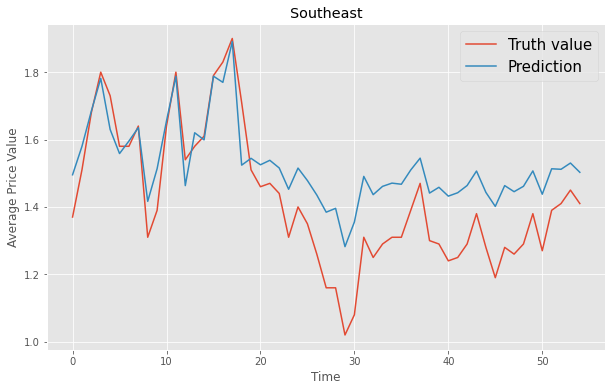

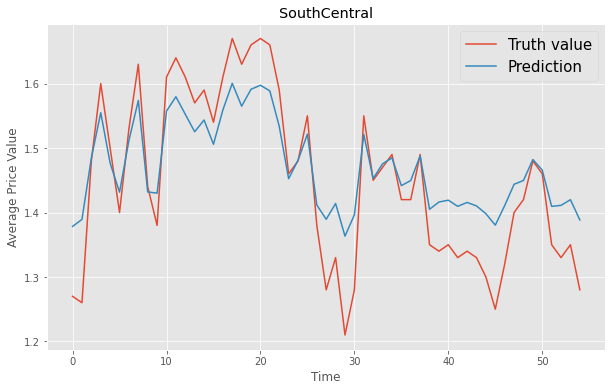

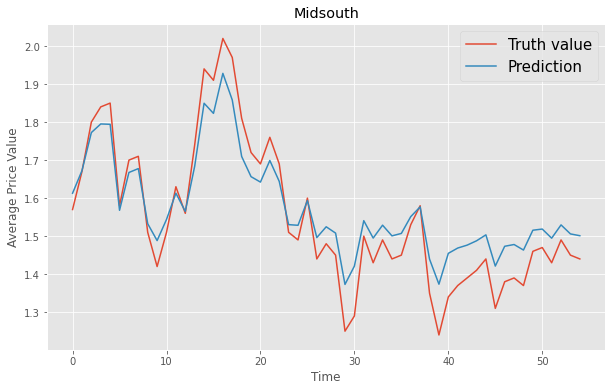

In [15]:
def plot_lstm_series(time, series,title, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Average Price Value")
    plt.legend(fontsize=15)
    plt.title(title)

# Choosing 2 regions out of 5
forecast_regions = list(forecast_df.region.unique())

# Predicting and plotting 2 regions
for each_region in forecast_regions:
  predict_df = forecast_df[forecast_df.region==each_region]
  predict_series = predict_df.drop(columns=["region"]).values
  predict_series = predict_series.reshape(1,len(f_series),6)
  LSTM_forecast = lstm_model.predict(predict_series)
  LSTM_forecast = LSTM_forecast[0,:,0]
  
  plt.figure(figsize=(10, 6))
  plot_lstm_series(list(range(0,len(predict_series[0,:,0]))), list(predict_series[0,:,0]),title=each_region,label="Truth value")
  plot_lstm_series(list(range(0,len(predict_series[0,:,0]))), LSTM_forecast,title=each_region,label="Prediction")
  plt.show()